In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# Read the CSV file with pandas
df1_train = pd.read_csv('./data/train1.txt', header=None, delimiter='\t')
df1_test = pd.read_csv('./data/test1.txt', header=None, delimiter='\t')
df2_train = pd.read_csv('./data/train2.txt', header=None, delimiter='\t')
df2_test = pd.read_csv('./data/test2.txt', header=None, delimiter='\t')

In [2]:
import random
# Set the seed for the random number generator in numpy
np.random.seed(42)

# Set the seed for the random number generator in Python's built-in random module
random.seed(42)

In [3]:
x_train1, y_train1 = df1_train[0].to_numpy(), df1_train[1].to_numpy()
x_test1, y_test1 = df1_test[0].to_numpy(), df1_test[1].to_numpy() 

In [4]:
x_train2, y_train2 = df2_train[0].to_numpy(), df2_train[1].to_numpy()
x_test2, y_test2 = df2_test[0].to_numpy(), df2_test[1].to_numpy() 

In [5]:
def shuffle_data(X: np.array, Y: np.array) -> (np.array, np.array):
    idx = np.random.permutation(len(X))
    assert len(X) == len(Y)
    return X[idx], Y[idx]    

In [6]:
def mini_batch(xt, yt, mini_batch_size, shuffle = None):
        """
        It is a generator functions that generates&yields mini batches

        """
        # Shuffle dataset
        def create_permutation(x, y):
            perm = np.random.permutation(len(x))
            return x[perm], y[perm]

        if shuffle is not None:
            x_shuffle, y_shuffle = create_permutation(xt, yt)
        else:
            x_shuffle, y_shuffle = xt[:], yt[:] 

        # m: number of examples
        m = yt.shape[1]

        number_of_mini_batches = int(m/mini_batch_size)

        for k in range(number_of_mini_batches): 
            mini_batch_X = x_shuffle[:, k*mini_batch_size : (k+1)*mini_batch_size]
            mini_batch_Y = y_shuffle[:, k*mini_batch_size : (k+1)*mini_batch_size]
            yield (mini_batch_X, mini_batch_Y)

        if (m % number_of_mini_batches) != 0:
            mini_batch_X = x_shuffle[:, number_of_mini_batches*mini_batch_size : m]
            mini_batch_Y = y_shuffle[:, number_of_mini_batches*mini_batch_size : m]
            yield (mini_batch_X, mini_batch_Y)

In [7]:
class Normalize:
    def __init__(self, data):
        self.mu = data.mean()
        self.std = data.std()
        
    def norm_distribution(self, data):
        return (data-self.mu) / self.std
    
    def de_norm_distribution(self, data):
        return data*self.std + self.mu
        

In [8]:
class Layer:
    def __init__(self, layer_size, activation, weight_initializer, bias_initializer,
                momentum=None, beta=None):
        # number neurons in the layer
        self.layer_size = layer_size
        
        # input size
        self.feature_size = None
        
        # activation function
        self.activation = activation
        
        # initializing method
        self.weight_initializer = weight_initializer
        self.bias_initializer = bias_initializer
        
        # momentum setting
        self.momentum = momentum
        self.beta = beta
        self.velocity : dict = None
        
        ### Forward Pass
        # a0 -> z1 = W1*a0 + b1 -> a1 = activation(z1) -> z2 = W2*a1 + b2 -> ...
        self.forward_dict = {'a0': None, 'W': None, 'b': None, 'Z': None, 'A': None}
        
        ### Backward pass
        # dW = dz/dw * da/dz * dL/da = dz/dw * dZ
        # db = dz/db * da/dz * dL/da = dz/db * dZ
        # dZ = da/dz * dL/da
        self.backward_dict = {'dW': None, 'dB': None, 'dL_da0': None }
        
        #
        self.result_dict = None
        self.result_dict_meta_data = None
    
    def gradient_update(self, lr: float):
        # momentum condition
        if self.momentum is not None:
            if self.velocity is None:
                # initialize velocity
                self.velocity = dict()
                self.velocity['W'] = np.zeros_like(self.forward_dict['W'])
                self.velocity['b'] = np.zeros_like(self.forward_dict['b'])
            
            # calculate velocity
            dW_V = self.beta*self.velocity['W'] + (1 - self.beta)*self.backward_dict['dW']
            db_V = self.beta*self.velocity['b'] + (1 - self.beta)*self.backward_dict['dB']
            
            # update velocity
            self.velocity['W'] = dW_V
            self.velocity['b'] = db_V
            
            # update gradients
            self.forward_dict['W'] = self.forward_dict['W'] - lr*dW_V
            self.forward_dict['b'] = self.forward_dict['b'] - lr*db_V
        
        # vanilla gradient update
        if self.momentum is None and self.velocity is None:
            self.forward_dict['W'] = self.forward_dict['W'] - lr*self.backward_dict['dW']
            self.forward_dict['b'] = self.forward_dict['b'] - lr*self.backward_dict['dB']
        
            

In [9]:
# (layer_size, input_size) 

def random_init(shape: tuple) -> np.array:
    return np.random.randn(*shape) * 0.01

def zero_init(shape: tuple) -> np.array:
    return np.zeros(shape)

def ones_init(shape: tuple) -> np.array:
    return np.ones(shape)

def glorot_normal(shape: tuple) -> np.array:
    std = np.sqrt(2 / np.sum(shape))
    return np.random.normal(0, std, shape)

def glorot_uniform(shape: tuple) -> np.array:
    std = np.sqrt(6 / np.sum(shape))
    return np.random.normal(0, std, shape)

def xavier(shape: tuple) -> np.array:
    std = np.sqrt(1 / shape[1])
    return np.random.normal(0, std, shape)

def he_init(shape: tuple) -> np.array:
    std = np.sqrt(2 / shape[1])
    return np.random.normal(0, std, shape) 


class MSE:
    @staticmethod
    def cost(y_pred, y_true):
        assert y_true.shape[0] == y_pred.shape[0]
        y_diff = y_pred - y_true
        
        return (1/(y_true.shape[0])) * np.dot(y_diff, y_diff.T)
    
    @staticmethod
    def cost_with_std(y_pred, y_true):
        assert y_true.shape[0] == y_pred.shape[0]
        y_diff = y_pred - y_true
        cost = (1/y_true.shape[0]) * np.dot(y_diff, y_diff.T)
        
        print("mean", np.mean(np.multiply(y_diff, y_diff.T)))
        std = np.sqrt(np.var(np.multiply(y_diff, y_diff.T), ddof=0))
        
        return cost, std
    
    @staticmethod
    def derivative(y_pred, y_true):
        assert y_true.shape[0] == y_pred.shape[0]

        return (2/y_true.shape[0]) * (y_pred-y_true)

class ReLu:
    @staticmethod
    def p(z):
        return np.maximum(z, 0)

    @staticmethod
    def derivative(a):
        return np.where(a > 0, 1, 0)

    

class Tanh:
    @staticmethod
    def p(z):
        return np.tanh(z)

    @staticmethod
    def derivative(a):
        return 1 - a**2

class Linear:
    @staticmethod
    def p(x):
        return x

    @staticmethod
    def derivative(x):
        return np.ones_like(x)

    
class Sigmoid:
    @staticmethod
    def p(z):
        return 1./(1 + np.exp(-z))
    
    @staticmethod
    def derivative(a):
        return a * (1-a)

In [10]:
class ANN:
    def __init__(self):
        self.layers = []
        
        self.lr = None
        self.loss_function = None
        self.batch_size = None
        self.initial_weight = []
        self.m = None
        
        # normalization parameters. type: Normalize class instance
        self.x_norm = None
        self.y_norm = None
    
    def add_layer(self, layer: Layer):
        self.layers.append(layer)
        
    def _initialize_weights(self, input_shape):
        feature_size = input_shape[0]
        input_size = feature_size

        for layer in self.layers:
            layer_size = layer.layer_size
            layer.feature_size = input_size
            
            layer.forward_dict['W'] = layer.weight_initializer((layer_size, input_size))
            layer.forward_dict['b'] = layer.bias_initializer((layer_size, 1))
            
            input_size = layer_size
            
    def do_pass(self, a, layer):

        layer.forward_dict['a0'] = a.copy()
        W = layer.forward_dict['W'].copy()
        b = layer.forward_dict['b'].copy()

        # Z.shape = (layer size, m)
        Z = np.dot(W, a) + b
        
        A = layer.activation.p(Z)
     
        layer.forward_dict['Z'] = Z.copy()
        layer.forward_dict['A'] = A.copy()
    
        return A
    
    def forward_pass(self, Xb, Yb):
        """
        Xb: batch of the train data
        Yb: labels of the Xb
        """
        
        a = Xb.copy()
        
        for layer in self.layers:
            a_prev = a
            next_layers_activation = self.do_pass(a_prev, layer)
            a = next_layers_activation.copy()
    
        cost = self.loss_function.cost(a, Yb)
        
        return cost, a
    
    
    def backward_pass(self, Yb):
        
        # preds.shape = (m, 1)
        preds = self.layers[-1].forward_dict['A']
        
        # derivative(shape(m,1), shape(m,1))
        dL_da = self.loss_function.derivative(preds, Yb)
        
        for layer in reversed(self.layers):
            
            a = layer.forward_dict['A']
            
            # da_dz.shape = (layer.layer_size, m)
            da_dz = layer.activation.derivative(a)
            
            # dL_dz.shape = (layer.layer_size, m)
            assert da_dz.shape == dL_da.shape
            dL_dz = np.multiply(da_dz, dL_da)
            
            # a0.shape = (layer.feature_size, m)
            a0 = layer.forward_dict['a0']
            
            # (layer.layer_size, m) (m, layer.feature_size)
            layer.backward_dict['dW'] = (1/self.m) * np.dot(dL_dz, a0.T)
            layer.backward_dict['dB'] = (1/self.m) * np.sum(dL_dz, axis=1, keepdims=True)
            
            # dL_da0.shape -> (layer.feature_size, layer.layer_size) * (layer.layer_size, m)
            # dL_da0.shape = (layer.feature_size, m)
            dL_da0 = np.dot(layer.forward_dict['W'].T, dL_dz)
            
            # new dL-dA is the iterative way of passing last preds
            dL_da = dL_da0.copy()
            
            # update gradients
            layer.gradient_update(self.lr)
    
    def fit(self, X: np.array, Y: np.array, lr: float, epochs: int, loss_function, 
            number_of_samples, loss_threshold=None, p_threshold=None, batch_size=None, shuffle=None):
        
        X = X.reshape(-1, number_of_samples)
        Y = Y.reshape(1, number_of_samples)
        
        self.x_norm = Normalize(X)
        self.y_norm = Normalize(Y)
        X = self.x_norm.norm_distribution(X)
        Y = self.y_norm.norm_distribution(Y)        
                
        self._initialize_weights(X.shape)
        
        # for debug
        self.initial_weight.append(self.layers[0].forward_dict["W"])
        self.initial_weight.append(self.layers[0].forward_dict["b"])
        
        # batch size setting
        if batch_size is None:
            self.batch_size = number_of_samples
        else:
            self.batch_size = batch_size
    
        self.lr = lr
        self.loss_function = loss_function
        
        patience = 0
        best_loss = float('inf')
        best_dict = {}
        best_dict_meta_data = {'cost': None, 'epoch': None}
        
        def copy_parameters(layers):
            best_dict = {}
            for layer in layers:
                best_dict[layer] = copy.deepcopy(layer.forward_dict)
            return best_dict
        
        def change_parameters(best_dict, layers):
            for layer in layers:
                layer.forward_dict = copy.deepcopy(best_dict[layer])            
        
       
        costs = list()
        
        for epoch in range(epochs):
            epoch_costs = 0
            for xb, yb in mini_batch(X, Y, mini_batch_size = self.batch_size, shuffle = shuffle):
                #print(f"{X.shape=}, {Y.shape=}, {xb.shape=}, {yb.shape=}")
                self.m = yb.shape[1]
                # X.shape (m, ..), Y.shape (m, 1)
                cost, pred = self.forward_pass(xb, yb)

                # Y.shape (m, 1)
                self.backward_pass(yb)
                epoch_costs += float(cost.flatten())
            
            costs.append(epoch_costs)
            
            # Patience Stop Condition, for the epoch
            if (p_threshold is not None) and (loss_threshold is None):
                
                if patience == p_threshold:
                    change_parameters(best_dict, self.layers)
                    return costs[:best_dict_meta_data['cost'][1]+1]
            
                # 1e-5 is the improvement amount
                if epoch_costs + 1e-5 <= best_loss:
                    best_loss = epoch_costs

                    # update
                    patience = 0
                    best_dict = copy_parameters(self.layers)
                    best_dict_meta_data['cost'] = (epoch_costs, len(costs)) 
                    best_dict_meta_data['epoch'] = epoch + 1

                    self.result_dict = best_dict
                    self.result_dict_meta_data = best_dict_meta_data
                else:
                    patience += 1
            
            
            # Loss Value Stop Condition, for the epoch
            if (loss_threshold is not None) and (p_threshold is None) and (epoch_costs <= loss_threshold):
                print(f"{epoch_costs=}, {loss_threshold=}")
                return costs
        
        if p_threshold is not None:
            change_parameters(best_dict, self.layers)
            return costs[:best_dict_meta_data['cost'][1]+1]
        
        # if it completes all epochs for the general cases and loss_stop condition
        return costs
        
   

    
    def predict(self, x: np.array, number_of_samples):
        a = x.reshape(-1, number_of_samples).copy()
        a = self.x_norm.norm_distribution(a)
        
        for layer in self.layers:
            W = layer.forward_dict['W'].copy()
            b = layer.forward_dict['b'].copy()
            
            assert W.shape[1] == a.shape[0], f"{W.shape=}, {a.shape=}"
            
            Z = np.dot(W, a) + b
            A = layer.activation.p(Z)
            a = A.copy()
        
        # a is the last activations
        return self.y_norm.de_norm_distribution(a)
    
    def evaluate(self, x: np.array, y: np.array, number_of_samples):
        y = y.reshape(-1, number_of_samples).copy()
        y = self.y_norm.norm_distribution(y)
        
        a = x.reshape(-1, number_of_samples).copy()
        a = self.x_norm.norm_distribution(a)
        
        for layer in self.layers:
            W = layer.forward_dict['W'].copy()
            b = layer.forward_dict['b'].copy()
            
            assert W.shape[1] == a.shape[0], f"{W.shape=}, {a.shape=}"
            
            Z = np.dot(W, a) + b
            A = layer.activation.p(Z)
            a = A.copy()
        
        # a is the last activations
        
        cost, std = self.loss_function.cost_with_std(a, y)
        
        preds = self.y_norm.de_norm_distribution(a)
        return cost, std, preds
        
            

In [18]:
def plots(costs, model, x, y, number_of_samples, label, x_axis, y_axis, print_cost=None, fig=None):
    if print_cost is not None:
        def pcost(costs):
            fig, ax = plt.subplots()
            ax.plot([i for i in range(len(costs))], costs,marker='o', linestyle='-', markersize=1)
            t = 'Train-COST-' + label + '.svg'
            ax.set_xlabel('Epochs')
            ax.set_ylabel('MSE Loss')
            ax.set_title('Train MSE Loss: ' + label)
            fig.tight_layout()
            fig.savefig(t, format='svg')
        pcost(costs)        
        
    cost__, std__, y_preds = model.evaluate(x, y, number_of_samples=number_of_samples)
    print(f"{cost__=}, {std__=}")
    
    fig, ax = plt.subplots()
    x_p = np.linspace(min(x), max(x), len(x)).reshape(1,-1)
    y_p=model.predict(x_p, number_of_samples=number_of_samples)

    # Plot the graph
    ax.scatter(x, y, color="blue", alpha=0.5, label='training data')
    ax.plot(x_p.flatten(), y_p.flatten(), color="black", label='decision line')
    # Add labels and title
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.set_title('Training Data: ' + label)
    ax.legend()
    fig.tight_layout()
    fig.savefig('Training Data: ' + label + ".svg", format='svg')

    return fig

In [19]:
def plot_test(model, x, y, number_of_samples, label, x_axis, y_axis, print_cost=None):
    if print_cost is not None:
        def pcost(costs):
            fig, ax = plt.subplots()
            ax.plot([i for i in range(len(costs))], costs,marker='o', linestyle='-', markersize=1)
            t = 'Test-COST-' + label + '.svg'
            ax.set_xlabel('Epochs')
            ax.set_ylabel('MSE Loss')
            ax.set_title('Test MSE Loss: ' + label)
            fig.tight_layout()
            fig.savefig(t, format='svg')
        pcost(costs)  
    
    fig, ax = plt.subplots()

    # plot the decision line
    x_p = np.linspace(min(x), max(x), len(x)).reshape(1,-1)
    y_p=model.predict(x_p, number_of_samples=number_of_samples)

    cost__, std__, y_preds = model.evaluate(x, y, number_of_samples=number_of_samples)
    print(f"{cost__=}, {std__=}")
    
    # Plot the graph
    ax.scatter(x, y_preds, color="orange", label='predictions')
    ax.plot(x_p.flatten(), y_p.flatten(), color="black", label="decision line")
    ax.scatter(x, y, color="blue", alpha=0.5, label='true values')
    
    #scatter predictions
    
    # Add labels and title
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.set_title('Test Data: ' + label)
    ax.legend()
    fig.tight_layout()
    fig.savefig('Test Data: ' + label + '.svg', format='svg')
    return fig

In [20]:
x_t = x_train1.copy()
y_t = y_train1.copy()

# TRAIN 1

In [152]:
model1 = ANN()

model1.add_layer(Layer(layer_size=8, activation=Tanh, 
                       weight_initializer=xavier, bias_initializer=zero_init))

model1.add_layer(Layer(layer_size=1, activation=Linear, 
                       weight_initializer=xavier, bias_initializer=zero_init))

costs = model1.fit(x_t, y_t, 0.01, 10000, MSE, number_of_samples=60, batch_size=10, p_threshold=5)


mean 1.1324127589077632e-06
cost__=array([[1.22849236]]), std__=0.020474872567554286


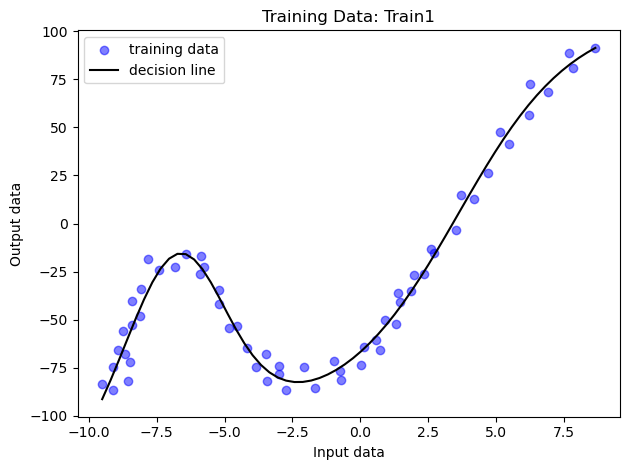

In [153]:
model1_fig_train1 = plots(costs, model1, x_t, y_t, number_of_samples=60,
                  label='Train1', x_axis='Input data', y_axis='Output data')

In [154]:
model1.result_dict_meta_data

{'cost': (1.2660925018380806, 9998), 'epoch': 9998}

mean 0.004012689758717274
cost__=array([[1.29729329]]), std__=0.0313858274913738


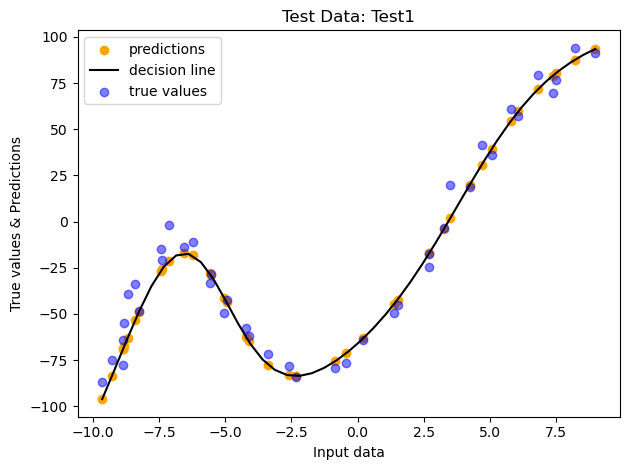

In [147]:
model1_fig_test1 = plot_test(model1, x_test1, y_test1, number_of_samples=41,
         label='Test1', x_axis="Input data", y_axis="True values & Predictions")

# Train2

In [148]:
x_t2 = x_train2.copy()
y_t2 = y_train2.copy()

In [149]:
model2 = ANN()

model2.add_layer(Layer(layer_size=12, activation=Tanh, 
                       weight_initializer=xavier, bias_initializer=zero_init, momentum=True, beta=0.999))

model2.add_layer(Layer(layer_size=1, activation=Linear, 
                       weight_initializer=xavier, bias_initializer=zero_init, momentum=True, beta=0.999))
    
costs = model2.fit(x_t2, y_t2, 0.1, 20000, MSE, number_of_samples=229, batch_size=32,
                   p_threshold=None, shuffle=False)


mean 7.24282703595665e-09
cost__=array([[12.3557556]]), std__=0.05395526460745453


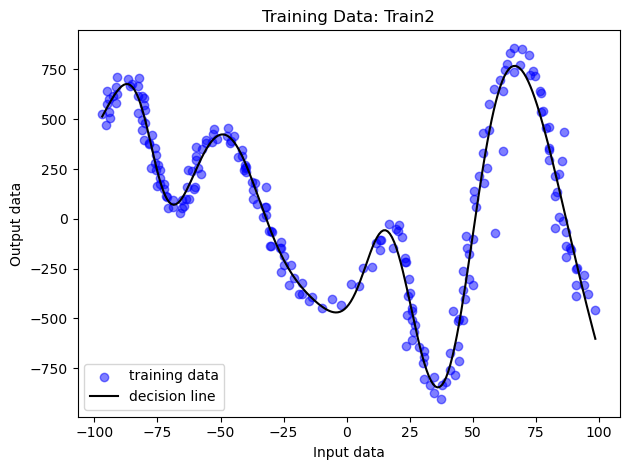

In [150]:
model2_fig_train2 = plots(costs, model2, x_t2, y_t2, number_of_samples=229,
                  label='Train2', x_axis='Input data', y_axis='Output data')

### test2

mean 1.253643304975085e-05
cost__=array([[14.01116266]]), std__=0.1522952458213152


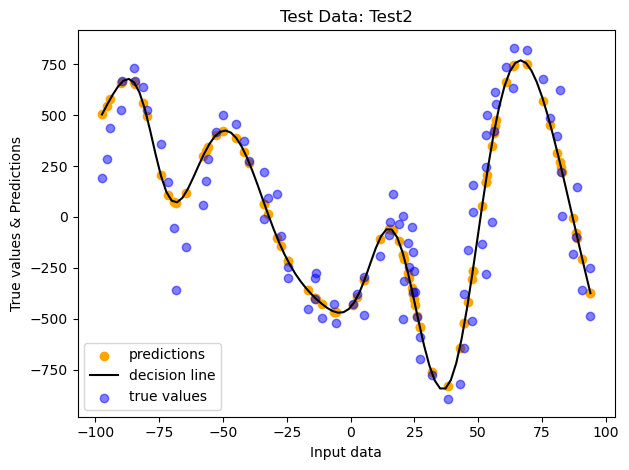

In [151]:
model2_fig_test2 = plot_test(model2, x_test2, y_test2, number_of_samples=92,
                  label='Test2', x_axis="Input data", y_axis="True values & Predictions")

# Linear Regression and Non-Linear Regression

### Linear

### Train1

mean 2.4671622769447923e-19
cost__=array([[30.83384367]]), std__=0.5138973945308118


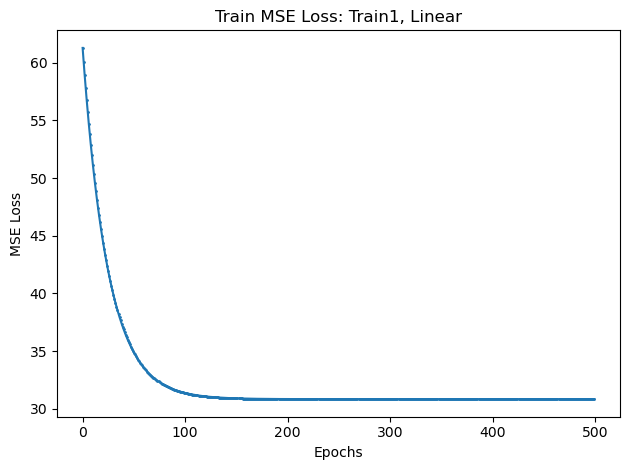

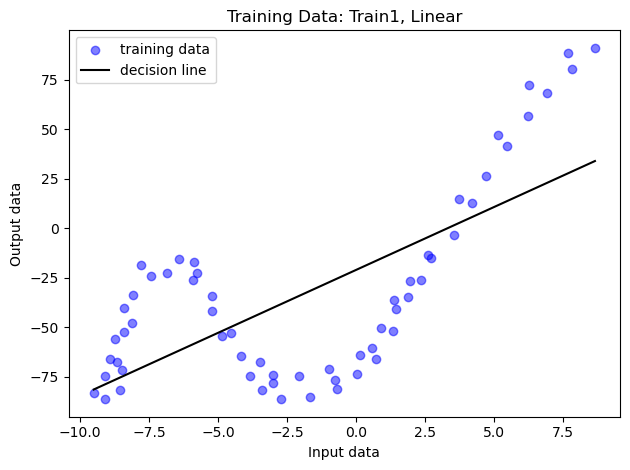

In [70]:
mL2 = ANN()
mL2.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=random_init, bias_initializer=zero_init))
cost_ml2 = mL2.fit(x_t, y_t, 0.01, 500, MSE, number_of_samples=60, batch_size=60)
mL2_fig_train1 = plots(cost_ml2, mL2, x_t, y_t, number_of_samples=60,
                  label='Train1, Linear', x_axis='Input data', y_axis='Output data', print_cost=True)


mean 0.0667033078953318
cost__=array([[24.310276]]), std__=0.58916965003822


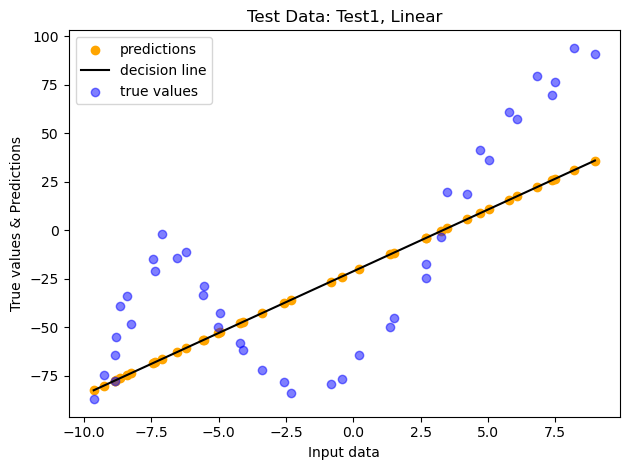

In [71]:
mL2_fig_test1 = plot_test(mL2, x_test1, y_test1, number_of_samples=41,
         label='Test1, Linear', x_axis="Input data", y_axis="True values & Predictions")

### Train2

mean -9.738612751998856e-19
cost__=array([[205.04135355]]), std__=0.8953770897373212


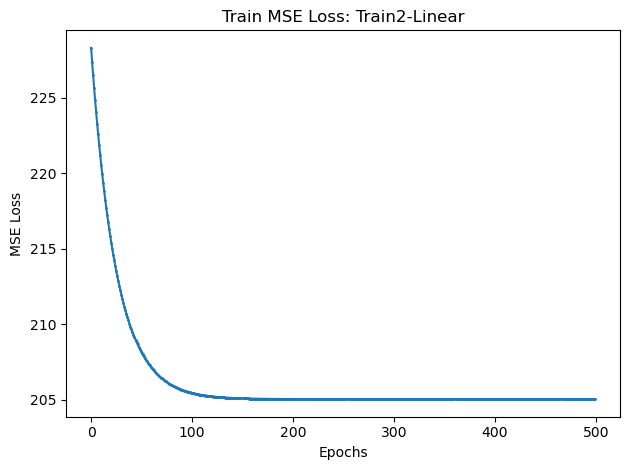

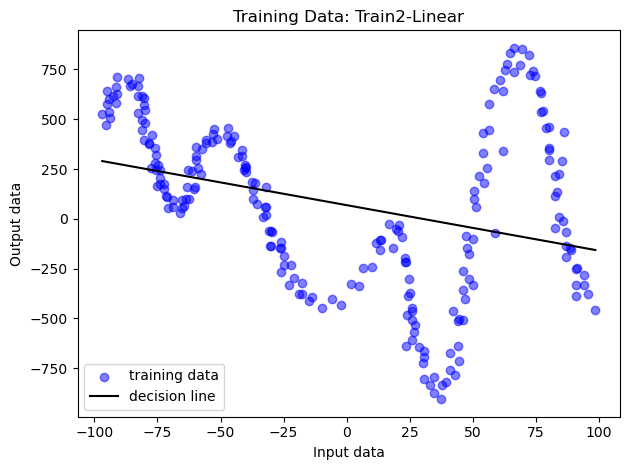

In [72]:
mL2_train2 = ANN()
mL2_train2.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=random_init, bias_initializer=zero_init))
cost_ml2_train2 = mL2_train2.fit(x_t2, y_t2, 0.01, 500, MSE, number_of_samples=229, batch_size=229)
mL2_fig_train2 = plots(cost_ml2_train2, mL2_train2, x_t2, y_t2, number_of_samples=229,
                  label='Train2-Linear', x_axis='Input data', y_axis='Output data', print_cost=True)


mean 0.010701391549654308
cost__=array([[90.03870936]]), std__=0.9786231145319759


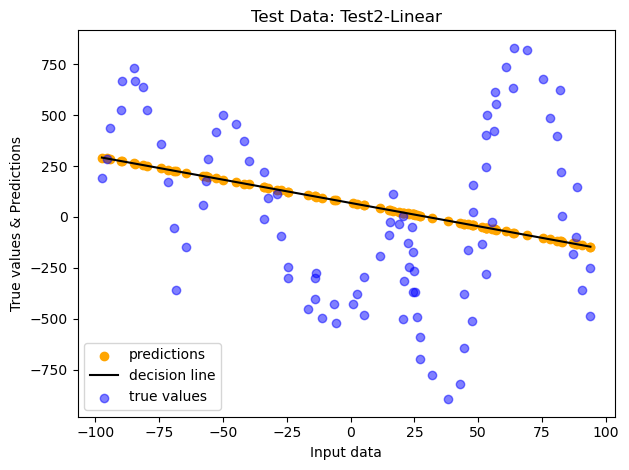

In [73]:
mL2_fig_test2 = plot_test(mL2_train2, x_test2, y_test2, number_of_samples=92,
         label='Test2-Linear', x_axis="Input data", y_axis="True values & Predictions")

---
---

### non-linear
### train1

In [42]:
# 1-1/? = x 
moment_last_x_items = 1 /(1-0.98)
print(f"{moment_last_x_items=}")

moment_last_x_items=49.99999999999996


mean 1.1042358372581298e-08
cost__=array([[1.57405167]]), std__=0.026234194554046523
1.5740571494931352 <<<


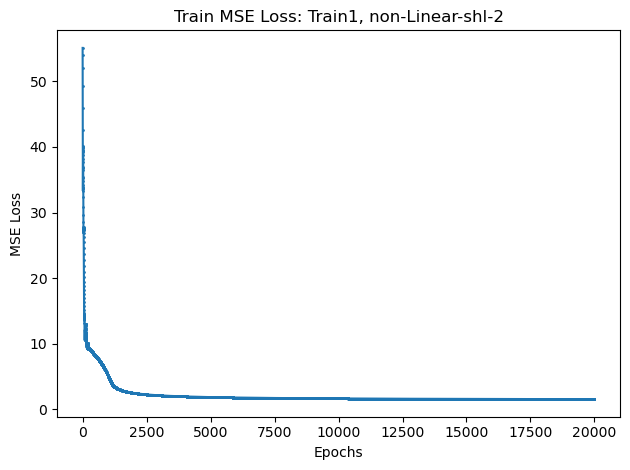

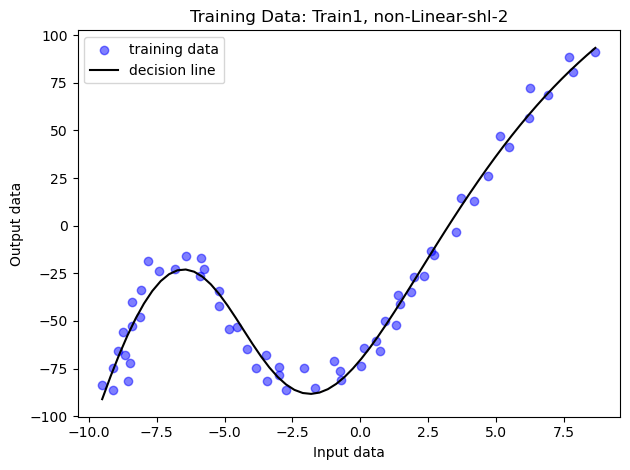

In [43]:
# used momentum and full batch to fit the concave part around 6
mL2_non = ANN()
mL2_non.add_layer(Layer(layer_size=2, activation=Tanh, weight_initializer=xavier, bias_initializer=zero_init, momentum=True, beta=0.98))
mL2_non.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, bias_initializer=zero_init,  momentum=True, beta=0.98))

cost_ml2_non = mL2_non.fit(x_t, y_t, 0.5, 20000, MSE, number_of_samples=60, batch_size=60)
mL2_fig_train1_non = plots(cost_ml2_non, mL2_non, x_t, y_t, number_of_samples=60,
                  label='Train1, non-Linear-shl-2', x_axis='Input data', y_axis='Output data', print_cost=True)
print(cost_ml2_non[-1],"<<<")

mean 0.004416365646303062
cost__=array([[1.51934047]]), std__=0.03679297817897073


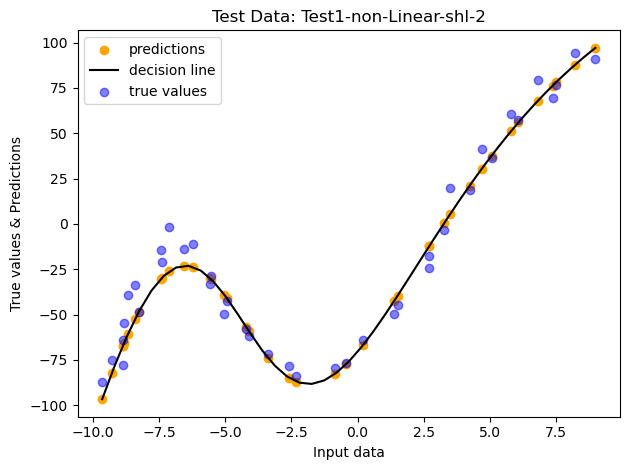

In [44]:
mL2_non_test1 = plot_test(mL2_non, x_test1, y_test1, number_of_samples=41,
         label='Test1-non-Linear-shl-2', x_axis="Input data", y_axis="True values & Predictions")

### train2

mean 3.544923044877356e-07
cost__=array([[49.01084798]]), std__=0.21402117021360334
49.01091720060259


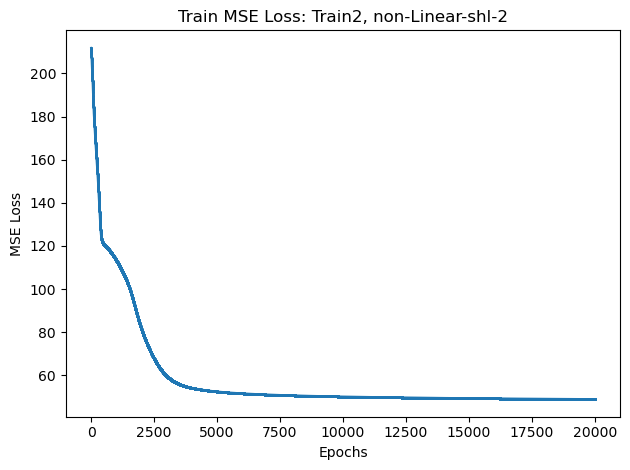

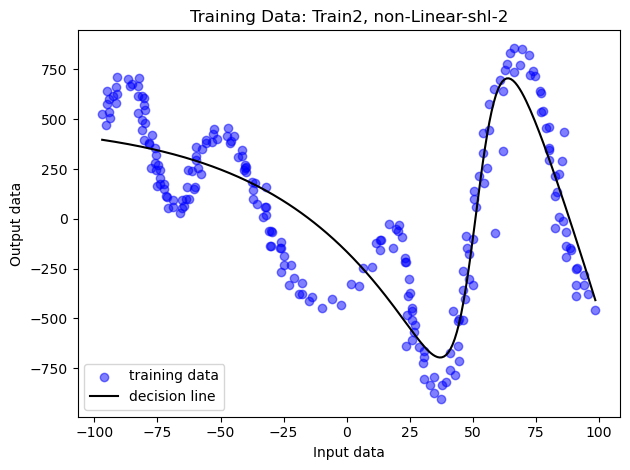

In [45]:
# used momentum and full batch to fit the concave part around 6
mL2_non_train2 = ANN()
mL2_non_train2.add_layer(Layer(layer_size=2, activation=Tanh, weight_initializer=xavier, bias_initializer=zero_init, momentum=True, beta=0.98))
mL2_non_train2.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, bias_initializer=zero_init,  momentum=True, beta=0.98))

cost_ml2_non_train2 = mL2_non_train2.fit(x_t2, y_t2, 0.1, 20000, MSE, number_of_samples=229, batch_size=229)
mL2_fig_train1_non_train2 = plots(cost_ml2_non_train2, mL2_non_train2, x_t2, y_t2, number_of_samples=229,
                  label='Train2, non-Linear-shl-2', x_axis='Input data', y_axis='Output data', print_cost=True)

print(cost_ml2_non_train2[-1])

mean 7.503153803906565e-05
cost__=array([[35.33375331]]), std__=0.3840625286834139


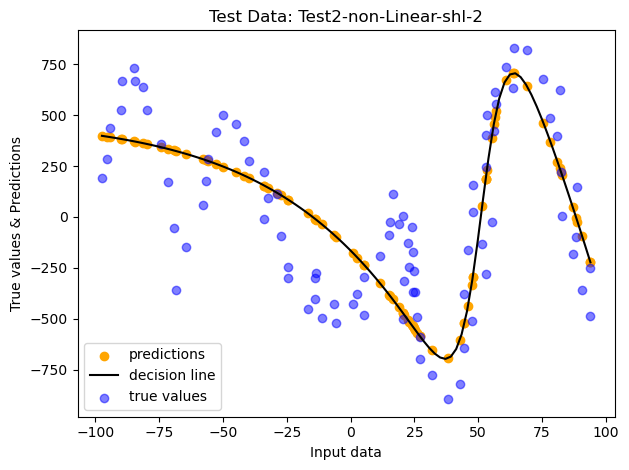

In [46]:
mL2_non_test2 = plot_test(mL2_non_train2, x_test2, y_test2, number_of_samples=92,
         label='Test2-non-Linear-shl-2', x_axis="Input data", y_axis="True values & Predictions")

## Hidden layer size: 4

mean 1.6998982813004913e-10
cost__=array([[1.14727445]]), std__=0.019121240822141117
30.833843671276753


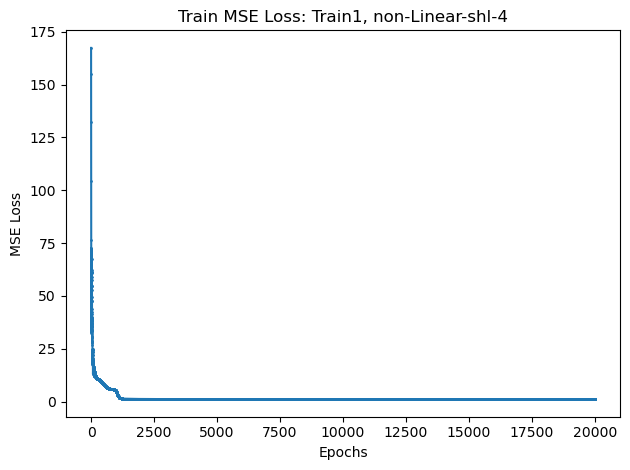

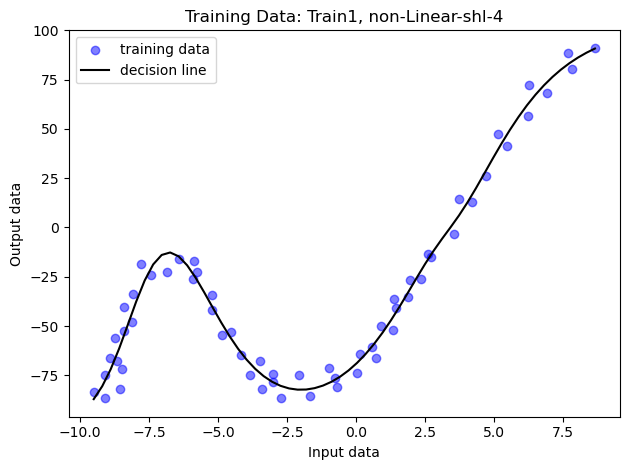

In [47]:
# used momentum and full batch to fit the concave part around 6
mL4_non = ANN()
mL4_non.add_layer(Layer(layer_size=4, activation=Tanh, weight_initializer=xavier, bias_initializer=zero_init, momentum=True, beta=0.98))
mL4_non.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, bias_initializer=zero_init,  momentum=True, beta=0.98))

cost_ml4_non = mL4_non.fit(x_t, y_t, 0.5, 20000, MSE, number_of_samples=60, batch_size=60)
mL4_fig_train1_non = plots(cost_ml4_non, mL4_non, x_t, y_t, number_of_samples=60,
                  label='Train1, non-Linear-shl-4', x_axis='Input data', y_axis='Output data', print_cost=True)


mean 0.0033790255925064297
cost__=array([[1.19012312]]), std__=0.02883004926195832


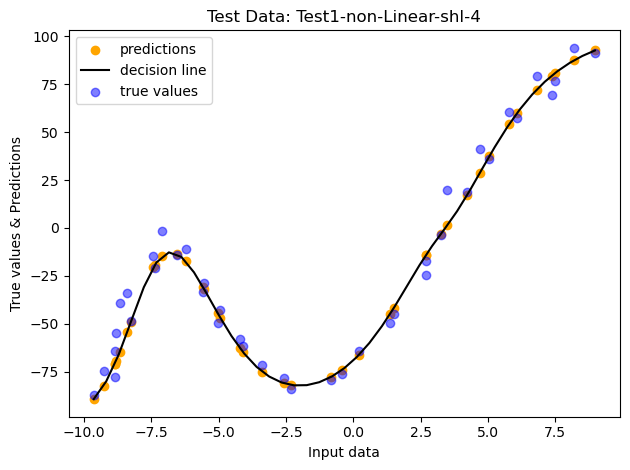

In [48]:
mL4_non_test1 = plot_test(mL4_non, x_test1, y_test1, number_of_samples=41,
         label='Test1-non-Linear-shl-4', x_axis="Input data", y_axis="True values & Predictions")

mean 1.4546191269158384e-09
cost__=array([[26.23608591]]), std__=0.11456806074954776


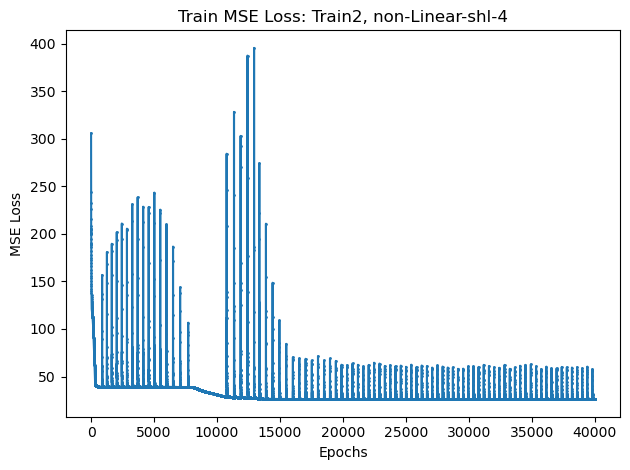

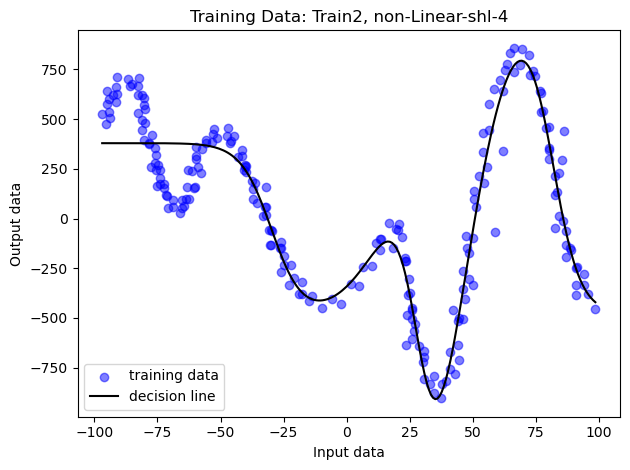

In [49]:
# used momentum and full batch to fit the concave part around 6
mL4_non_train2 = ANN()
mL4_non_train2.add_layer(Layer(layer_size=4, activation=Tanh, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.80))
mL4_non_train2.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.80))

cost_ml4_non_train2 = mL4_non_train2.fit(x_t2, y_t2, 0.75, 40000, MSE, number_of_samples=229, batch_size=229)
mL4_fig_train1_non_train2 = plots(cost_ml4_non_train2, mL4_non_train2, x_t2, y_t2, number_of_samples=229,
                  label='Train2, non-Linear-shl-4', x_axis='Input data', y_axis='Output data', print_cost=True)


mean 0.0002707050012452787
cost__=array([[19.94774038]]), std__=0.21682309599049387


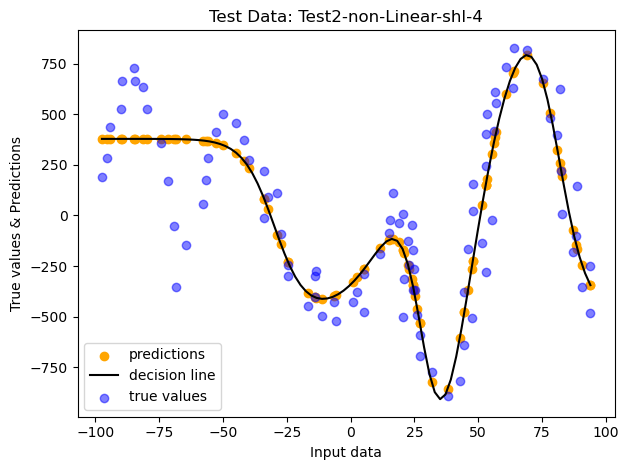

In [50]:
mL4_non_test2 = plot_test(mL4_non_train2, x_test2, y_test2, number_of_samples=92,
         label='Test2-non-Linear-shl-4', x_axis="Input data", y_axis="True values & Predictions")

### Hidden layer size = 8

mean 1.1208758346163463e-09
cost__=array([[1.2018193]]), std__=0.02003032161639932
30.833843671276753


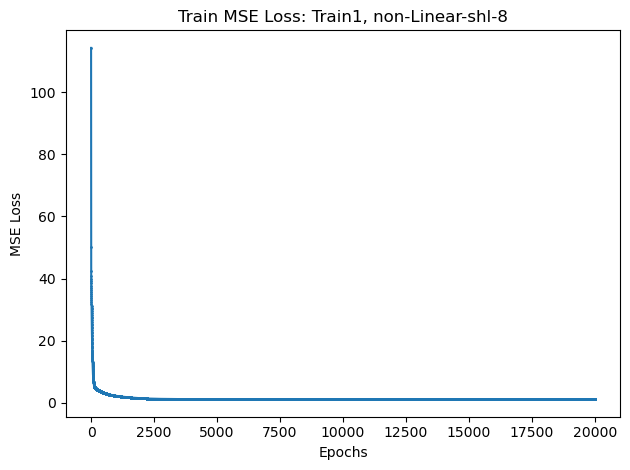

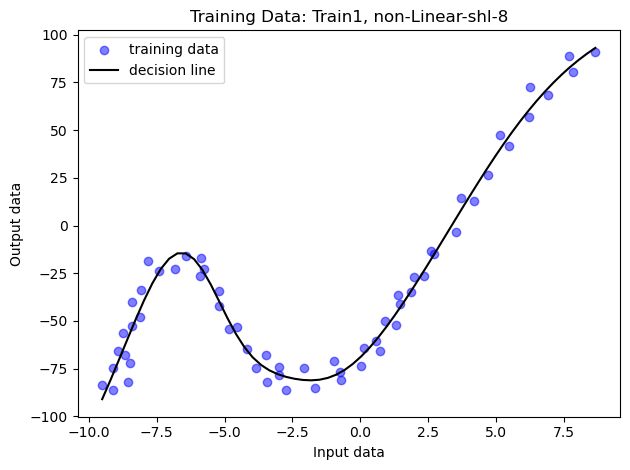

In [51]:
mL8_non = ANN()
mL8_non.add_layer(Layer(layer_size=8, activation=Tanh, weight_initializer=xavier, bias_initializer=zero_init))
mL8_non.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, bias_initializer=zero_init))

cost_ml8_non = mL8_non.fit(x_t, y_t, 0.1, 20000, MSE, number_of_samples=60, batch_size=60)
mL8_fig_train1_non = plots(cost_ml8_non, mL8_non, x_t, y_t, number_of_samples=60,
                  label='Train1, non-Linear-shl-8', x_axis='Input data', y_axis='Output data', print_cost=True)

print(cost_ml2[-1])

mean 0.00380967209301786
cost__=array([[1.20288864]]), std__=0.029090350573475574


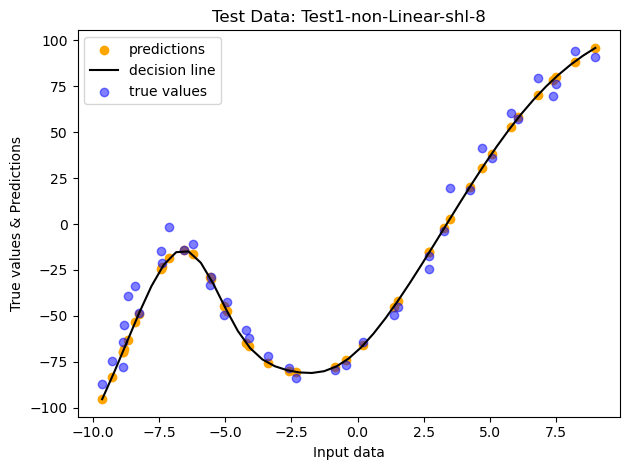

In [52]:
mL8_non_test1 = plot_test(mL8_non, x_test1, y_test1, number_of_samples=41,
         label='Test1-non-Linear-shl-8', x_axis="Input data", y_axis="True values & Predictions")

mean 8.337891574104899e-05
cost__=array([[13.36723382]]), std__=0.05837214051677223


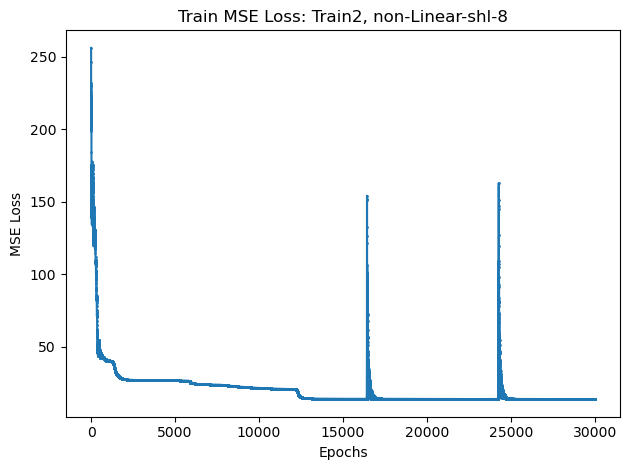

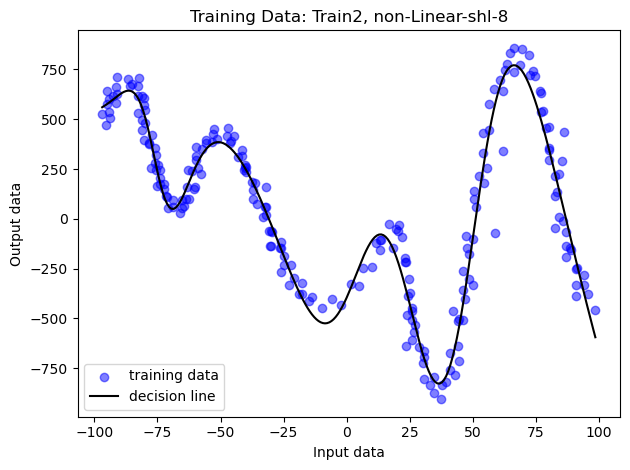

In [53]:
mL8_non_train2 = ANN()
mL8_non_train2.add_layer(Layer(layer_size=8, activation=Tanh, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.999))
mL8_non_train2.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.999))

cost_ml8_non_train2 = mL8_non_train2.fit(x_t2, y_t2, 0.3, 30000, MSE, number_of_samples=229, batch_size=32)
mL8_fig_train1_non_train2 = plots(cost_ml8_non_train2, mL8_non_train2, x_t2, y_t2, number_of_samples=229,
                  label='Train2, non-Linear-shl-8', x_axis='Input data', y_axis='Output data', print_cost=True)


mean 0.0005776689086358006
cost__=array([[15.33528212]]), std__=0.16668684817896948


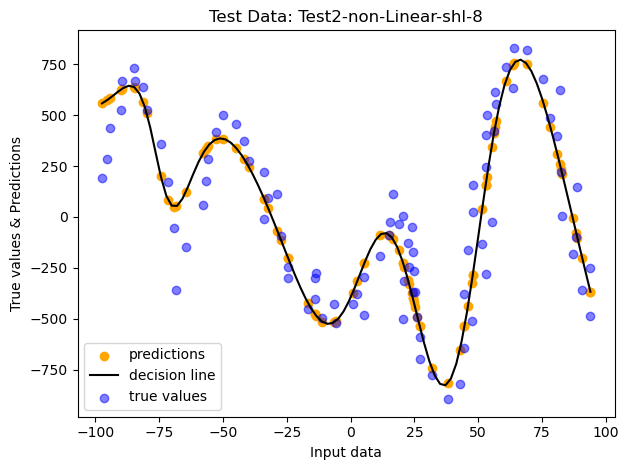

In [54]:
mL8_non_test2 = plot_test(mL8_non_train2, x_test2, y_test2, number_of_samples=92,
         label='Test2-non-Linear-shl-8', x_axis="Input data", y_axis="True values & Predictions")

In [55]:
### Hidden layer size = 16

mean 8.827116283383217e-11
cost__=array([[1.22315466]]), std__=0.02038591102780778


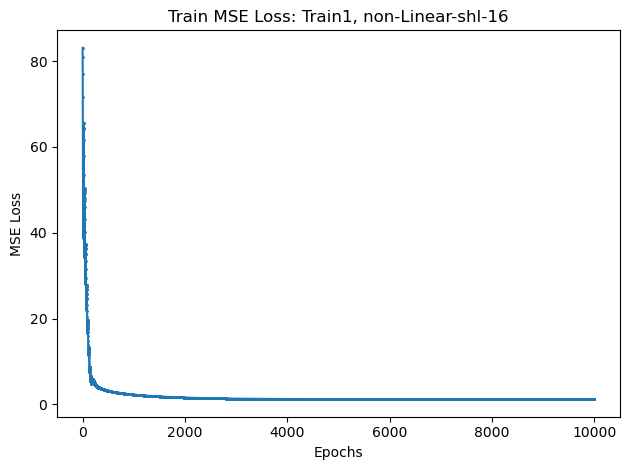

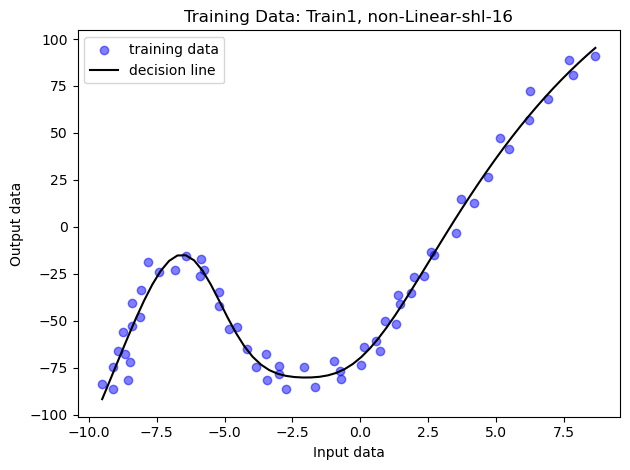

In [56]:
mL16_non = ANN()
mL16_non.add_layer(Layer(layer_size=16, activation=Tanh, weight_initializer=xavier, bias_initializer=zero_init, momentum=True, beta=0.98))
mL16_non.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, bias_initializer=zero_init,  momentum=True, beta=0.98))

cost_ml16_non = mL16_non.fit(x_t, y_t, 0.1, 10000, MSE, number_of_samples=60, batch_size=60)
mL16_fig_train1_non = plots(cost_ml16_non, mL16_non, x_t, y_t, number_of_samples=60,
                  label='Train1, non-Linear-shl-16', x_axis='Input data', y_axis='Output data', print_cost=True)


mean 0.003722801776805895
cost__=array([[1.24787077]]), std__=0.03020733484788665


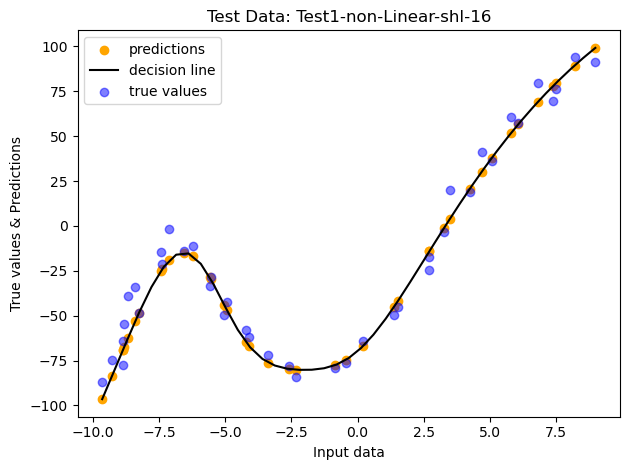

In [57]:
mL16_non_test1 = plot_test(mL16_non, x_test1, y_test1, number_of_samples=41,
         label='Test1-non-Linear-shl-16', x_axis="Input data", y_axis="True values & Predictions")

mean 6.171892513024303e-07
cost__=array([[11.24296731]]), std__=0.049095927129148814


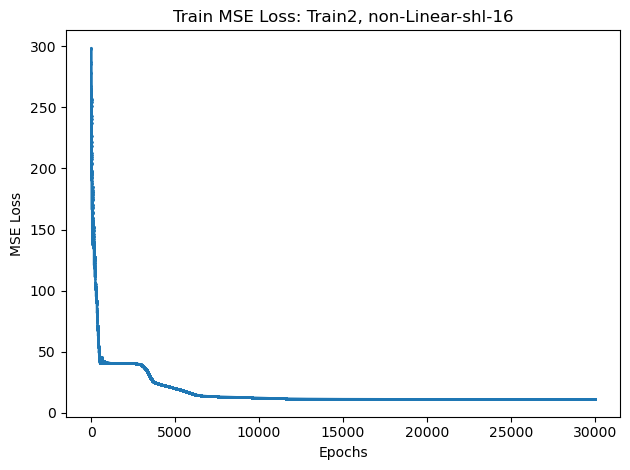

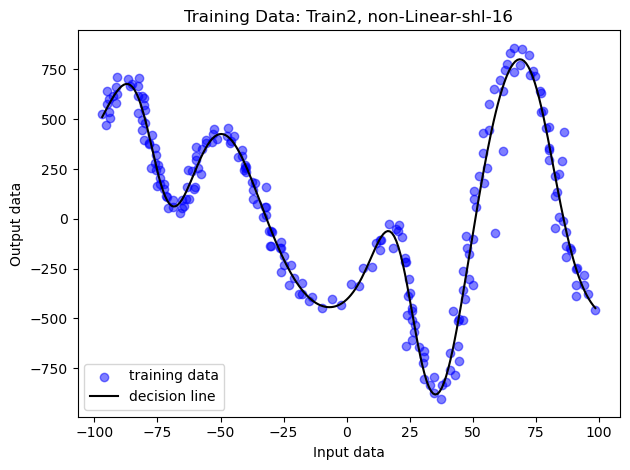

In [60]:
mL16_non_train2 = ANN()
mL16_non_train2.add_layer(Layer(layer_size=16, activation=Tanh, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.999))
mL16_non_train2.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.999))

cost_ml16_non_train2 = mL16_non_train2.fit(x_t2, y_t2, 0.1, 30000, MSE, number_of_samples=229, batch_size=32)
mL16_fig_train1_non_train2 = plots(cost_ml16_non_train2, mL16_non_train2, x_t2, y_t2, number_of_samples=229,
                  label='Train2, non-Linear-shl-16', x_axis='Input data', y_axis='Output data', print_cost=True)


mean 1.086796015976898e-05
cost__=array([[13.71254957]]), std__=0.14904945139853762


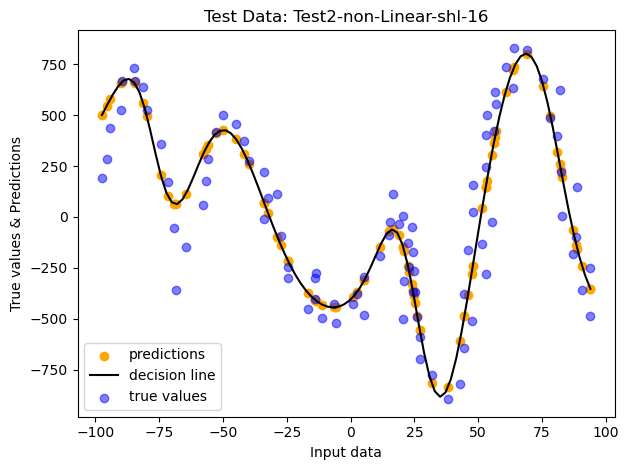

In [61]:
mL16_non_test2 = plot_test(mL16_non_train2, x_test2, y_test2, number_of_samples=92,
         label='Test2-non-Linear-shl-16', x_axis="Input data", y_axis="True values & Predictions")

###  d) LEARNING RATES

In [74]:
# stop training at cost = 11.25
loss_th = 12

### LR: 0.1

epoch_costs=11.999785103318146, loss_threshold=12
mean 9.06894094823067e-07
cost__=array([[11.92105466]]), std__=0.052057007222998455


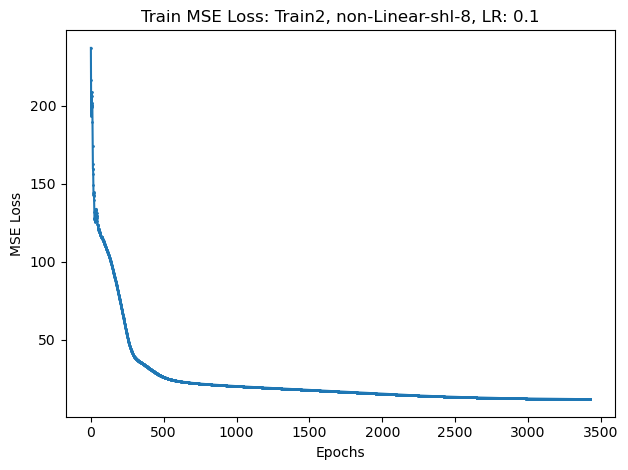

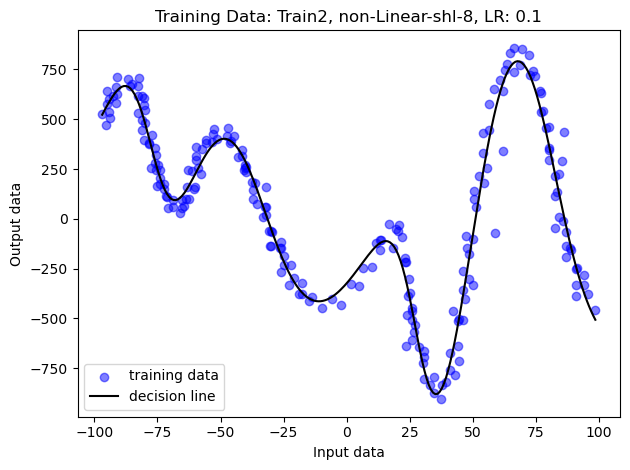

In [75]:
mL8_LR_01_non_train2 = ANN()
mL8_LR_01_non_train2.add_layer(Layer(layer_size=8, activation=Tanh, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.992))
mL8_LR_01_non_train2.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.992))

cost_mL8_LR_01_non_train2 = mL8_LR_01_non_train2.fit(x_t2, y_t2, 0.1, 30000, MSE, number_of_samples=229, batch_size=32,
                                              loss_threshold = loss_th)

mL8_LR_01_fig_train1_non_train2 = plots(cost_mL8_LR_01_non_train2, mL8_LR_01_non_train2, x_t2, y_t2, number_of_samples=229,
                  label='Train2, non-Linear-shl-8, LR: 0.1', x_axis='Input data', y_axis='Output data', print_cost=True)


In [76]:
print("number of epochs:", len(cost_mL8_LR_01_non_train2))

number of epochs: 3430


### LR: 0.01

epoch_costs=11.99981046583853, loss_threshold=12
mean 9.316450558363422e-07
cost__=array([[11.98171438]]), std__=0.05232189685617365


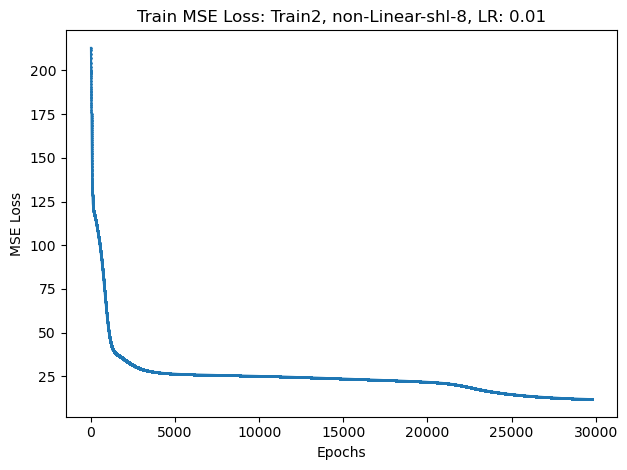

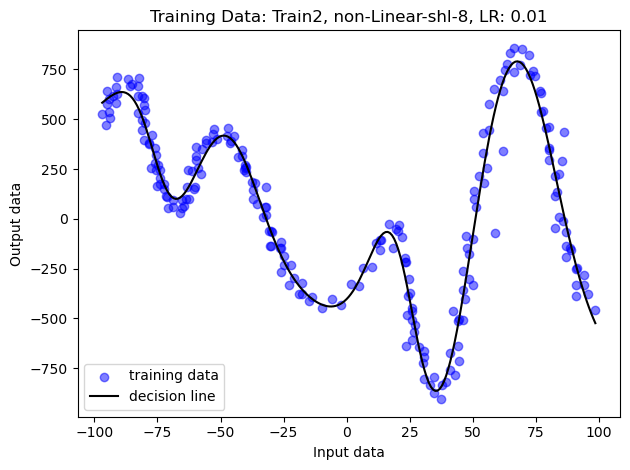

In [77]:
mL8_LR_001_non_train2 = ANN()
mL8_LR_001_non_train2.add_layer(Layer(layer_size=8, activation=Tanh, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.995))
mL8_LR_001_non_train2.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.995))

cost_mL8_LR_001_non_train2 = mL8_LR_001_non_train2.fit(x_t2, y_t2, 0.01, 30000, MSE, number_of_samples=229, batch_size=16,
                                              loss_threshold = loss_th)

mL8_LR_001_fig_train1_non_train2 = plots(cost_mL8_LR_001_non_train2, mL8_LR_001_non_train2, x_t2, y_t2, number_of_samples=229,
                  label='Train2, non-Linear-shl-8, LR: 0.01', x_axis='Input data', y_axis='Output data', print_cost=True)


In [78]:
print("number of epochs:", len(cost_mL8_LR_001_non_train2))

number of epochs: 29782


### LR: 0.001

mean 1.8261644763397941e-06
cost__=array([[18.94822571]]), std__=0.0827433436958503


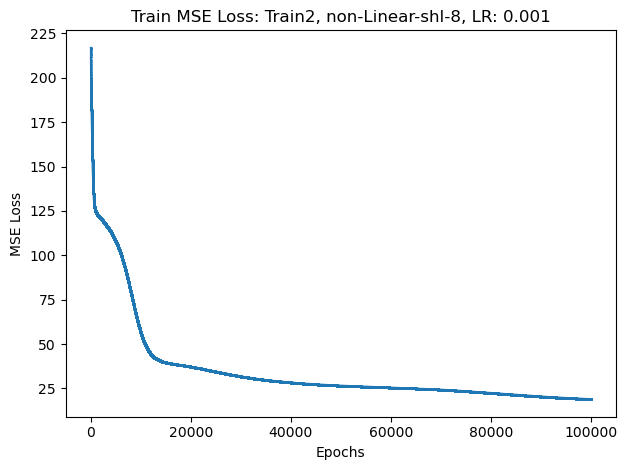

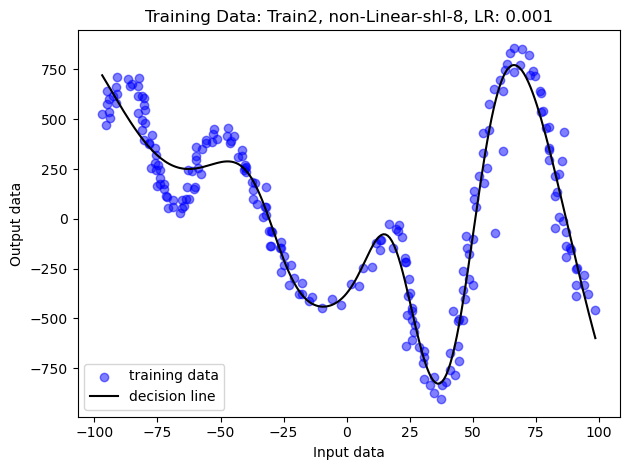

In [89]:
mL8_LR_0001_non_train2 = ANN()
mL8_LR_0001_non_train2.add_layer(Layer(layer_size=8, activation=Tanh, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.995))
mL8_LR_0001_non_train2.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.995))

cost_mL8_LR_0001_non_train2 = mL8_LR_0001_non_train2.fit(x_t2, y_t2, 0.001, 100000, MSE, number_of_samples=229, 
                                                         batch_size=16,
                                              loss_threshold = loss_th)

mL8_LR_0001_fig_train1_non_train2 = plots(cost_mL8_LR_0001_non_train2, mL8_LR_0001_non_train2, x_t2, y_t2, number_of_samples=229,
                  label='Train2, non-Linear-shl-8, LR: 0.001', x_axis='Input data', y_axis='Output data', print_cost=True)


In [91]:
print("number of epochs:", len(cost_mL8_LR_0001_non_train2))

number of epochs: 100000


### LR: 0.0001

epoch_costs=11.999836349064491, loss_threshold=12
mean 6.986123868339809e-07
cost__=array([[11.98151448]]), std__=0.05232102390400097


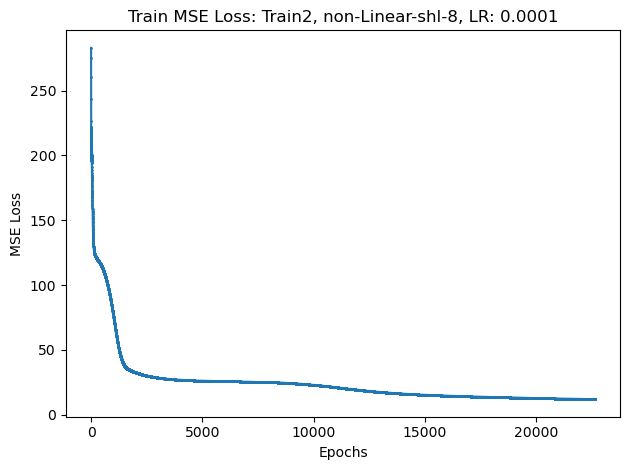

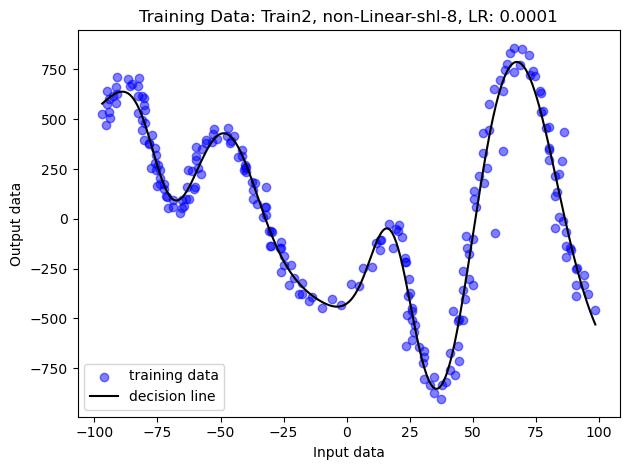

In [90]:
mL8_LR_00001_non_train2 = ANN()
mL8_LR_00001_non_train2.add_layer(Layer(layer_size=8, activation=Tanh, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.995))
mL8_LR_00001_non_train2.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.995))

cost_mL8_LR_00001_non_train2 = mL8_LR_00001_non_train2.fit(x_t2, y_t2, 0.01, 100000, MSE, number_of_samples=229, batch_size=16,
                                              loss_threshold = loss_th)

mL8_LR_00001_fig_train1_non_train2 = plots(cost_mL8_LR_00001_non_train2, mL8_LR_00001_non_train2, x_t2, y_t2, number_of_samples=229,
                  label='Train2, non-Linear-shl-8, LR: 0.0001', x_axis='Input data', y_axis='Output data', print_cost=True)


In [93]:
print("number of epochs:", len(cost_mL8_LR_00001_non_train2))

number of epochs: 22631


### e) With and Without Momentum

mean 0.009830537951445622
cost__=array([[17.96117722]]), std__=0.07781458645430778


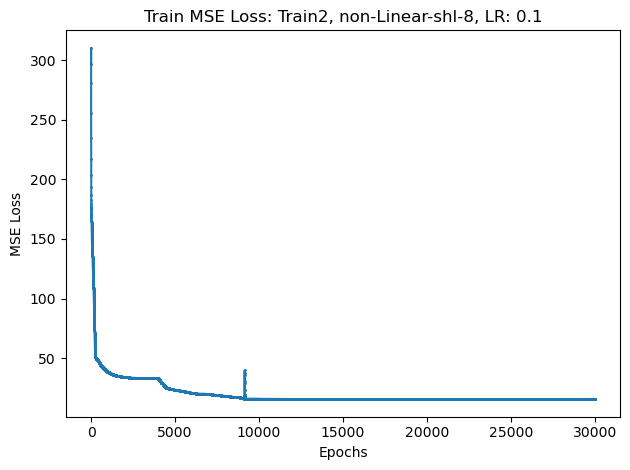

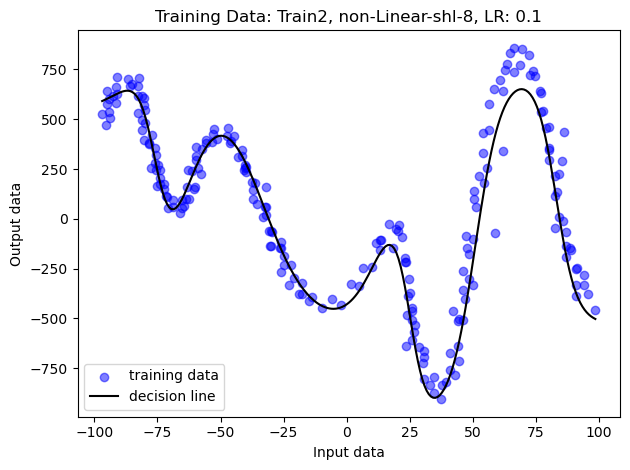

In [94]:
mL8_LR_01_non_train2 = ANN()
mL8_LR_01_non_train2.add_layer(Layer(layer_size=8, activation=Tanh, weight_initializer=xavier, bias_initializer=zero_init))
mL8_LR_01_non_train2.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, bias_initializer=zero_init))

cost_mL8_LR_01_non_train2 = mL8_LR_01_non_train2.fit(x_t2, y_t2, 0.1, 30000, MSE, number_of_samples=229, batch_size=32,
                                              loss_threshold = None)

mL8_LR_01_fig_train1_non_train2 = plots(cost_mL8_LR_01_non_train2, mL8_LR_01_non_train2, x_t2, y_t2, number_of_samples=229,
                  label='Train2, non-Linear-shl-8, LR: 0.1', x_axis='Input data', y_axis='Output data', print_cost=True)


In [96]:
th = 18

epoch_costs=17.999983176733156, loss_threshold=18
mean 0.0013373794090823267
cost__=array([[23.74633866]]), std__=0.10368717745831238


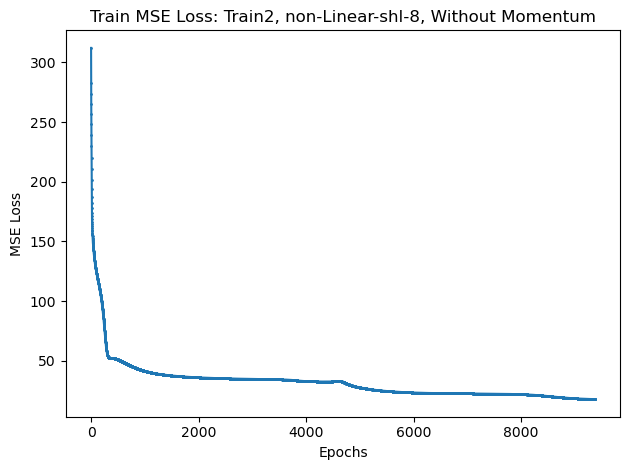

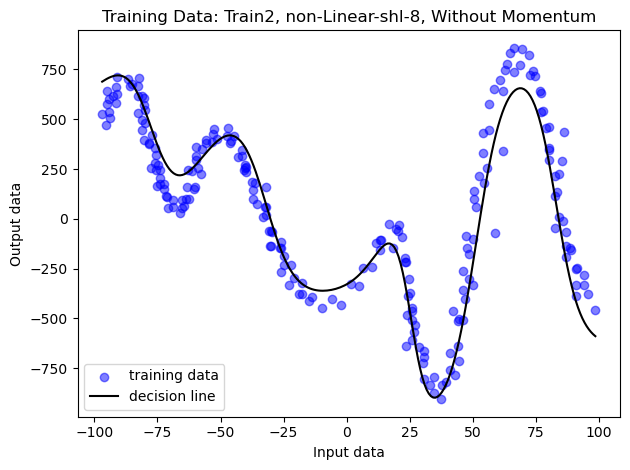

In [133]:
mL8_LR_01_wo_non_train2 = ANN()

mL8_LR_01_wo_non_train2.add_layer(Layer(layer_size=8, activation=Tanh, weight_initializer=xavier,
                                        bias_initializer=zero_init))

mL8_LR_01_wo_non_train2.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, 
                                        bias_initializer=zero_init))

cost_mL8_LR_01_wo_non_train2 = mL8_LR_01_wo_non_train2.fit(x_t2, y_t2, 0.1, 30000, MSE, number_of_samples=229, 
                                                           batch_size=32, loss_threshold = 18)

mL8_LR_01_wo_fig_train1_non_train2 = plots(cost_mL8_LR_01_wo_non_train2, mL8_LR_01_wo_non_train2, x_t2, y_t2, number_of_samples=229,
                  label='Train2, non-Linear-shl-8, Without Momentum', x_axis='Input data', y_axis='Output data', print_cost=True)


In [134]:
len(cost_mL8_LR_01_wo_non_train2)

9375

epoch_costs=17.99552606893842, loss_threshold=18
mean 3.559699522242445e-06
cost__=array([[17.92804109]]), std__=0.07828838896773266


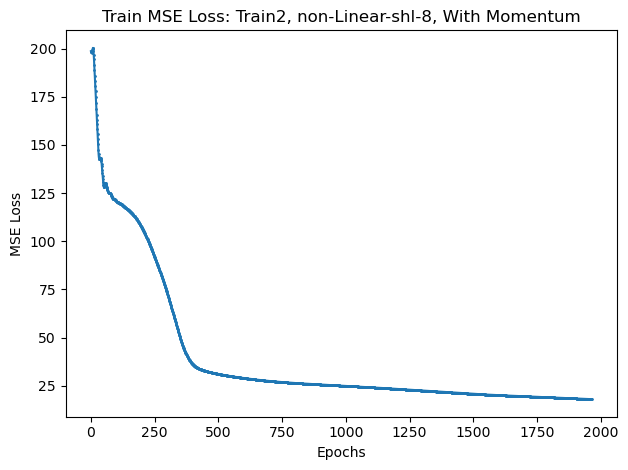

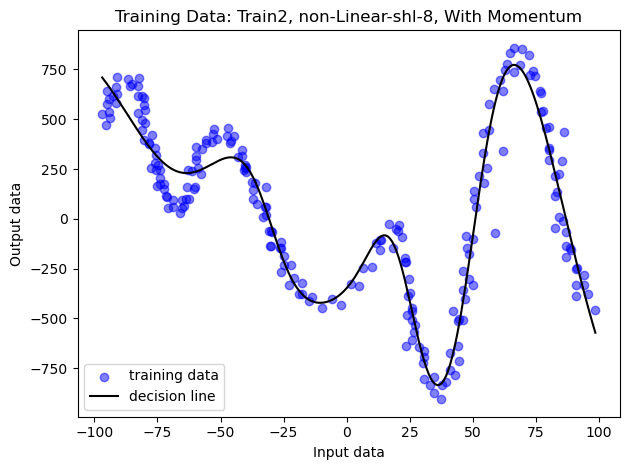

In [136]:
mL8_LR_01_wm_non_train2 = ANN()

mL8_LR_01_wm_non_train2.add_layer(Layer(layer_size=8, activation=Tanh, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.992))

mL8_LR_01_wm_non_train2.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, bias_initializer=zero_init, 
                               momentum=True, beta=0.992))

cost_mL8_LR_01_wm_non_train2 = mL8_LR_01_wm_non_train2.fit(x_t2, y_t2, 0.1, 30000, MSE, number_of_samples=229, 
                                              batch_size=32, loss_threshold = 18)

mL8_LR_01_wm_fig_train1_non_train2 = plots(cost_mL8_LR_01_wm_non_train2, mL8_LR_01_wm_non_train2, x_t2, y_t2, number_of_samples=229,
                  label='Train2, non-Linear-shl-8, With Momentum', x_axis='Input data', y_axis='Output data', print_cost=True)


In [137]:
len(cost_mL8_LR_01_non_train2)

30000

# Stochastic vs. Batch

mean 0.0029308695860673375
cost__=array([[12.75509276]]), std__=0.05562193084348048


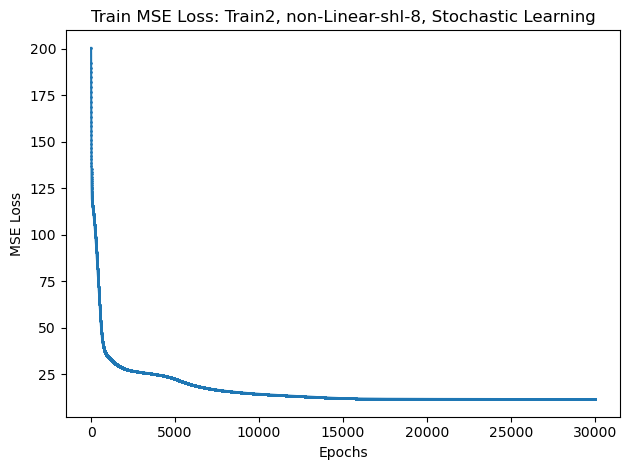

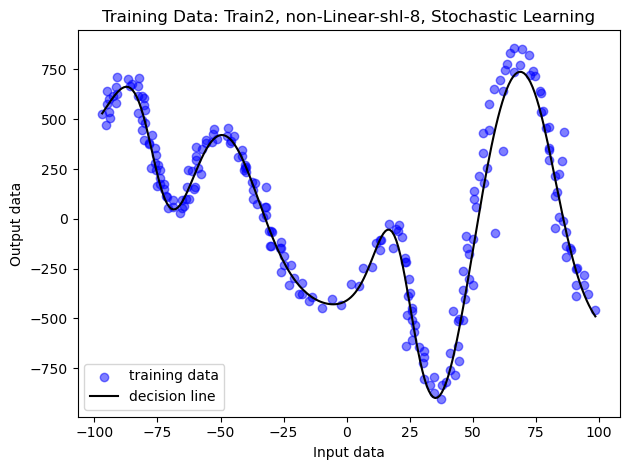

In [138]:
mL8_LR_01_stoc_non_train2 = ANN()

mL8_LR_01_stoc_non_train2.add_layer(Layer(layer_size=8, activation=Tanh, weight_initializer=xavier,
                                        bias_initializer=zero_init))

mL8_LR_01_stoc_non_train2.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, 
                                        bias_initializer=zero_init))

cost_mL8_LR_01_stoc_non_train2 = mL8_LR_01_stoc_non_train2.fit(x_t2, y_t2, 0.001, 30000, MSE, number_of_samples=229,
                                                               batch_size=1, loss_threshold = None, shuffle=True)

mL8_LR_01_stoc_fig_train1_non_train2 = plots(cost_mL8_LR_01_stoc_non_train2, mL8_LR_01_stoc_non_train2, x_t2, y_t2, number_of_samples=229,
                  label='Train2, non-Linear-shl-8, Stochastic Learning', x_axis='Input data', y_axis='Output data', print_cost=True)


In [142]:
len(cost_mL8_LR_01_stoc_non_train2)

30000

mean 0.0034393565312219767
cost__=array([[14.05506047]]), std__=0.06127936739622873


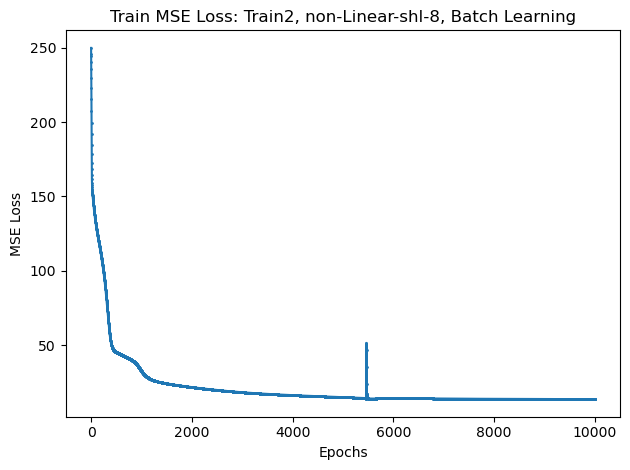

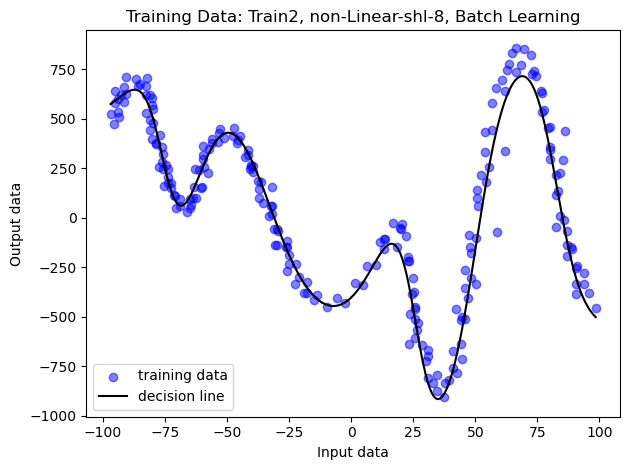

In [139]:
mL8_LR_01_batch_non_train2 = ANN()

mL8_LR_01_batch_non_train2.add_layer(Layer(layer_size=8, activation=Tanh, weight_initializer=xavier,
                                        bias_initializer=zero_init))

mL8_LR_01_batch_non_train2.add_layer(Layer(layer_size=1, activation=Linear, weight_initializer=xavier, 
                                        bias_initializer=zero_init))

cost_mL8_LR_01_batch_non_train2 = mL8_LR_01_batch_non_train2.fit(x_t2, y_t2, 0.07, 10000, MSE, number_of_samples=229,
                                                               batch_size=32)

mL8_LR_01_batch_fig_train1_non_train2 = plots(cost_mL8_LR_01_batch_non_train2, mL8_LR_01_batch_non_train2, x_t2, y_t2, number_of_samples=229,
                  label='Train2, non-Linear-shl-8, Batch Learning', x_axis='Input data', y_axis='Output data', print_cost=True)


In [143]:
len(cost_mL8_LR_01_batch_non_train2)

10000